Code was developed together with Agajan Torayev and Tobias Elvermann.

In [29]:
import datetime

now = datetime.datetime.now()

# Clustering and Topic Models

## Summer School JGU Mainz — Advanced Methods in Behavioral Economics, 2021

### Carina I. Hausladen

In [30]:
print(now.strftime("%Y-%m-%d"))

2021-09-26


In [31]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [32]:
from __future__ import print_function

import warnings

warnings.simplefilter("ignore")

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
%matplotlib inline

import nltk

from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from string import punctuation

from tqdm import tqdm_notebook

import bokeh.plotting as bp
from bokeh.models import HoverTool
from bokeh.plotting import show, output_notebook, reset_output
from bokeh.models.sources import ColumnDataSource

tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [33]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/carinah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carinah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data
Data and research idea are provided by [Prof. Dr. Martin Fochmann, FU Berlin](https://www.wiwiss.fu-berlin.de/fachbereich/bwl/pruefungs-steuerlehre/fochmann/Team/Prof_-Dr_-Fochmann/index.html) <br>
Data includes tax reports from German companies listed in the STOXX Europe 600. <br>

y: hand-coded <br>
X: if the keywords tax* and/or risk* were found, 15 words before and after the keyword were extracted and entered as a separate row.

**Goal**

* With clustering, we aim to extract information from annual reports with respect to which strategies companies undertake in order to avoid possible fines from not complying with tax risk laws. 
* y3 indicates that a paragraph discusses "tax risk management".

In [34]:
df = pd.read_csv("data/tax_risk_tokenized.csv")
df.head()

,x_sentences,company,y1,y2,y3,x
0,in the event of increases and decreases in val...,acs,1,1,1,the event increase and decrease value the moni...
1,"ACS Group since 2011, has de? ned a risk con...",acs,1,0,0,ac group since ha ned risk control policy that...
2,rec oGnition Revenue is recognised to the...,acs,0,0,0,rec ognition revenue recognised the extent tha...
3,salary is paid into an external fund. In add...,acs,0,0,0,salary paid into external fund addition turner...
4,"them. The lawsuits, although numerous, repre...",acs,0,0,0,them the lawsuit although numerous represent s...


# K-means
[scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#k-means) <br>

* It scales well to large number of samples and has been used across a large range of application areas in many different fields.
* This algorithm requires the number of clusters to be specified.
* The k-means algorithm divides a set of $n$ samples $x$ into $k$ disjoint clusters $c$, each described by the mean $\mu_j$ of the samples in the cluster. 
* The means are commonly called the cluster "centroids"; note that they are not, in general, points from $x$, although they live in the same space.

* The K-means algorithm aims to choose centroids that minimise the within-cluster sum-of-squares criterion:
$$ \sum\limits_{i=1}^n \min_{\mu \epsilon C}(||x_i-\mu_j||^2)$$

## Preprocessing

In [35]:
dummy3_df = df[df['y3'] == 1].copy()
dummy3_df.reset_index(inplace=True)

### Define stop words

In [36]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words += [c for c in punctuation]

### Vectorizer

In [37]:
vectorizer = TfidfVectorizer(max_df=0.95,
                             min_df=2,
                             stop_words=stop_words,
                             decode_error='ignore')
X = vectorizer.fit_transform(dummy3_df['x'])
words = vectorizer.get_feature_names()

## Choosing k
[Nikita Sharma](https://heartbeat.comet.ml/understanding-the-mathematics-behind-k-means-clustering-40e1d55e2f4c)

There exist various methods to determine the optimal value of $k$.
In the following, we learn about
- distortion
- Silhouette Coefficient

### Elbow Method

* The distortion plots the various values of cost with changing $k$. 
* Distortion: Sum of squared distances of samples to their closest cluster center.
* The point where the distortion declines the most is the elbow point, the optimal value of $k$.

### Silhouette Coefficient
[scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

* The Silhouette Coefficient $s$ is defined for each sample and is composed of two scores:
    * $a$: The mean distance between a sample and all other points in the same cluster.
    * $b$: The mean distance between a sample and all other points in the next nearest cluster.
* The Silhouette Coefficient $s$ for a single sample is given as:

$$s=\frac{b-a}{max(a,b)}$$
* The value of $k$ that has the maximum value of $s$ is considered the optimal number of clusters.

In [38]:
distortions = []
sil_scores = []
k_max = 12
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = KMeans(n_clusters=k,
                          init='k-means++',
                          n_init=1,
                          random_state=42)
    kmeans_model.fit(X)
    sil_score = silhouette_score(X, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distortions.append(kmeans_model.inertia_)

  0%|          | 0/10 [00:00<?, ?it/s]

### Plot graphs to choose k

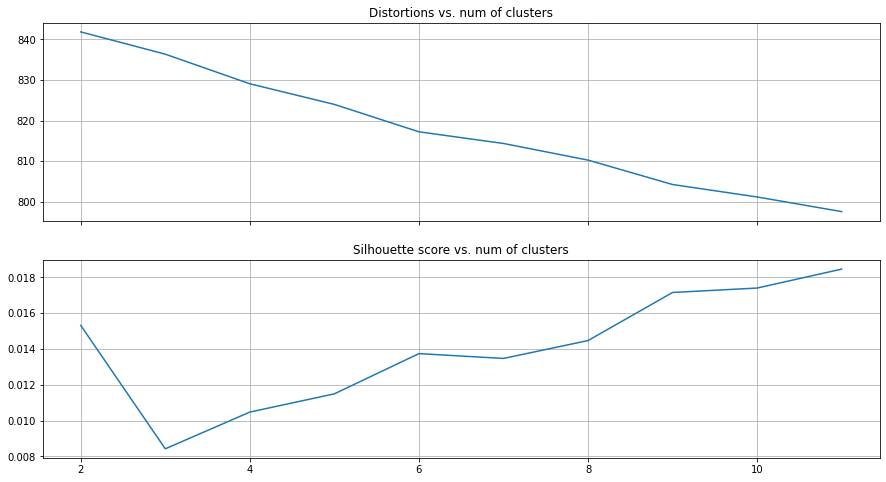

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))

ax1.plot(range(2, k_max), distortions)
ax1.set_title('Distortions vs. num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs. num of clusters')
ax2.grid(True)
plt.savefig("choosing_k.png")

## Refit
Based on observation we decided to choose k=7.

🤓: Choose a different $k$.

In [40]:
num_clusters = 7
kmeans_model = KMeans(n_clusters=num_clusters,
                      init='k-means++',
                      n_init=1,
                      random_state=42)

kmeans = kmeans_model.fit(X)
kmeans_clusters = kmeans.predict(X)
kmeans_distances = kmeans.transform(X)

## Let's interpret our clusters!

### Keywords by cluster

In [41]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)],
                           columns=['keywords_{0}'.format(i) for i in range(10)],
                           data=all_keywords)

keywords_df

,keywords_0,keywords_1,keywords_2,keywords_3,keywords_4,keywords_5,keywords_6,keywords_7,keywords_8,keywords_9
topic_0,committee,group,oversight,wa,management,executive,reviewed,financial,audit,operational
topic_1,control,management,group,internal,audit,committee,board,system,policy,compliance
topic_2,rate,interest,group,credit,currency,discount,value,cash,liquidity,capital
topic_3,income,liability,asset,provision,deferred,net,million,loss,total,current
topic_4,group,authority,change,provision,law,business,policy,jurisdiction,financial,management
topic_5,legal,management,group,company,regulatory,business,control,compliance,area,security
topic_6,department,group,control,accounting,internal,analysis,ensures,nancial,subsidiary,project


### Plot Clusters 

- In the following, we reduce the dimensionality to plot the result of the clustering in a two-dimensinoal space.
- PCA (principal component analysis) and t-SNE are two popular methods used to reduce high-dimensional data to a low-dimensional space.

#### How does t-SNE work?
[scikit-learn](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

* t-distributed Stochastic Neighbor Embedding (t-SNE) converts affinities of data points to probabilities. 
* The affinities in the original space are represented by Gaussian joint probabilities.
* The affinities in the embedded space are represented by Student’s t-distributions. 
* This allows t-SNE to be particularly sensitive to local structure.
* The [Kullback-Leibler (KL) divergence](https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810) of the joint probabilities in the original space and the embedded space will be minimized by gradient descent.
* Note that the KL divergence is not convex: It is useful to try different seeds and select the embedding with the lowest KL divergence.
* t-SNE is computationally expensive: It can take several hours on million-sample datasets where PCA will finish in seconds or minutes.

### Calculate t-SNE
🤓: Do different parameters (e.g. random state, number of iterations) affect the outcome?

In [42]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['cluster'] = kmeans_df['cluster'].map(str)
kmeans_df['x_sentences'] = dummy3_df['x_sentences']
kmeans_df['keywords'] = kmeans_df['cluster'].apply(lambda x: ", ".join(list(keywords_df.loc['topic_{}'.format(x)])))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 892 samples in 0.001s...
[t-SNE] Computed neighbors for 892 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 892 / 892
[t-SNE] Mean sigma: 0.016155
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.033936
[t-SNE] KL divergence after 500 iterations: 0.629360


### Plot t-sne

In [43]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
                     "#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
                     "#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
                     "#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

reset_output()
output_notebook()

Loading BokehJS ...

In [44]:
plot_kmeans = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering",
                        tools="pan,wheel_zoom,box_zoom,reset,hover,save",
                        x_axis_type=None, y_axis_type=None, min_border=1)

source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    x_sentences=kmeans_df['x_sentences'],
                                    keywords=kmeans_df['keywords'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips = {"keywords": "@keywords", "cluster": "@cluster"}
show(plot_kmeans)

# Topic Models

- Topic modeling is a type of statistical modeling for discovering the abstract "topics" that occur in a collection of documents. 
- Non-Negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) are two examples of topic models.

## NMF
[scikit-learn](https://scikit-learn.org/stable/modules/decomposition.html#nmf),
[Rob Salgado](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45)

* Non-Negative Matrix Factorization (NMF) is an unsupervised technique.
* NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional, non-negative representation. 

Example:

NMF decomposes the original matrix $A$ and returns two matrices $W$ and $H$.
 * $W$ represents the topics (by words) it found
 * $H$ the the coefficients (weights) for those topics. 
 
```
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)
```

Assuming $301$ articles $A$, $5000$ words $W$, and $30$ topics $H$:

```
A = 301 x 5000
W = 30 x 5000
H = 301 x 30
```

* NMF will modify the initial values of $W$ and $H$ so that the product approaches $A$ until either the approximation error converges or the max iterations are reached.

In [45]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=50, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 7
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, 
          l1_ratio=.5, init='nndsvd').fit(tfidf)

## LDA
[Tyler Doll](https://towardsdatascience.com/lda-topic-modeling-an-explanation-e184c90aadcd)

* Latent Dirichlet Allocation (LDA) is a form of unsupervised learning.
* It views documents as bags of words.
* Key assumption: 
  * A document was generated by picking a set of topics.
  * A topic was generated by picking a set of words. 
* LDA reverse engineers this process. 
* LDA can only use raw term counts for LDA because it is a probabilistic graphical model.

How it works
* $k$ topics are distributed across document $m$.
* Probabilistically assign word $w$ to a topic based on:
  - what topics are in document $m$
  - how many times word $w$ has been assigned a particular topic across all of the documents

In [46]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=50, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=42).fit(tf)

## Run NFM and LDA

In [47]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
#https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730 

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


documents = df['x'].tolist()
no_features = 500

## Most Predictive Words by Topic

### Most predictive words, nmf

In [48]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
liability current asset deferred total payable financial non reserve derivative
Topic 1:
rate value discount cash flow pre use growth used specific
Topic 2:
group management financial audit committee control business report company legal
Topic 3:
income net loss profit operating expense asset impairment year operation
Topic 4:
provision charge note litigation obligation dispute december current statement restructuring
Topic 5:
capital cost average equity return debt ratio weighted wacc premium
Topic 6:
million euro eur december wa year compared result increase group


### Most predictive words, lda

In [49]:
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
equity capital profit cost asset market rate business return ratio
Topic 1:
group management financial audit business legal company committee report control
Topic 2:
provision note liability statement financial obligation asset consolidated litigation balance
Topic 3:
year sale revenue group income xam value recognized company balance
Topic 4:
liability asset deferred current financial total equity non income payable
Topic 5:
rate value cash discount flow pre used market cost based
Topic 6:
income million provision net loss expense year operating profit euro


## Visualize Results
### LDA with count vectorizer

In [50]:
sums = np.sum(lda.transform(tf), axis=1)
np.count_nonzero(sums)  # no 0 inside that's good

23142

In [51]:
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='mmds')
panel
pyLDAvis.display(panel)

/Users/carinah/SS_JGU_21_ML/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/carinah/SS_JGU_21_ML/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/carinah/SS_JGU_21_ML/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/carinah/SS_JGU_21_ML/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/carinah/SS_JGU_21_ML/.venv/lib/python3.9/

## Get topic index for each document

The plot shows that topic 1 is the topic with most documents assigned.


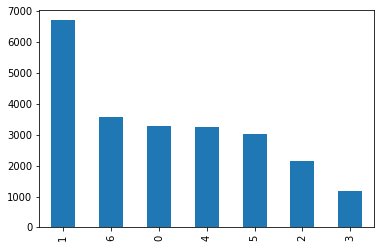

In [52]:
doc_topic = lda.transform(tf)

topic = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic.append(topic_most_pr)

se = pd.Series(topic)  #assign list to dataframe
df['topic'] = se.values

vc = df.topic.value_counts()
vc.plot(kind='bar')
print('The plot shows that topic', vc.argmax() + 1, 'is the topic with most documents assigned.')

## Print most informative paragraphs

In [53]:
doc_topic2 = pd.DataFrame(data=doc_topic, columns=('0', '1', '2', '3', '4', '5', '6'))
for column in doc_topic2:
    df[column] = doc_topic2[column]  #assign topic probabilities to df

for column in doc_topic2:  #print the paragraphs
    l0 = df.nlargest(1, column)
    print('These are the', len(l0), 'most informative paragraphs for topic', column, '\n')
    for i in range(1):
        print(l0.x_sentences.iloc[i], '\n')

These are the 1 most informative paragraphs for topic 0 

new business was due to three special effects. Details are pr   ovided in the EEV report for 2006 published on our website.   7   Risk-free interest rate + cost of capital  8   750 basis points above the risk-free return  9   Excluding tax effect   targets until 2010  Business group K   ey data Strategic   targets 2010 20091 2008 2007 2006  Non-life    reinsurance Combined ratio = 100% 98.2% 96.6% 95.4% 99.7% 100.8%  Net cat. loss expectancy  = 500 662 240 458 285 107  EBIT margin2 = 10% 16.3% 14.0% 0.1% 14.6% 14.2%  IVC margin3  = 2% n.  a. 1.7% (10.7%) 4.1% 5.1%  Life and health  r   einsurance  Gross premium growth 10\x9612% 12.4% 44.5% 1.7% 10.4% 15.2%  EBIT margin2 6\ 

These are the 1 most informative paragraphs for topic 1 

Management and   Group Legal & Compliance. The Committee meets on a quarterly   basis.   The  Committee  is  comprised  of  the  following  10  GMS   Departments each of which is responsible for prese